# Forecasting Monthly Revenue

## Objective
The goal of this notebook is to build forecasting models for monthly revenue using historical sales data. A baseline model is established and compared against a machine learning model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

## Load processed data

In [2]:
model_df = pd.read_csv('../data/processed/monthly_revenue.csv')
model_df['Month'] = pd.to_datetime(model_df['Month'])
model_df.head()

,Month,Country,revenue,orders,customers,quantity,year,month,revenue_lag_1,revenue_lag_2,revenue_lag_3,revenue_roll_3,revenue_roll_6
0,2010-07-01,Australia,686.12,3,2,224,2010,7,3214.78,2371.15,630.95,2072.293333,1324.505000
1,2010-08-01,Australia,176.00,1,1,88,2010,8,686.12,3214.78,2371.15,2090.683333,1393.675000
2,2010-09-01,Australia,785.83,2,2,293,2010,9,176.00,686.12,3214.78,1358.966667,1251.398333
3,2010-10-01,Australia,2989.15,9,8,1881,2010,10,785.83,176.00,686.12,549.316667,1310.805000
4,2010-11-01,Australia,18245.52,5,4,12900,2010,11,2989.15,785.83,176.00,1316.993333,1703.838333


## Define target and features

In [18]:
TARGET = 'revenue'
FEATURES = ['revenue_lag_1', 'revenue_lag_2', 'revenue_lag_3', 'revenue_roll_3', 'revenue_roll_6']

X = model_df[FEATURES]
y = model_df[TARGET]

## Train / test split (time-based)

In [19]:
split_date = model_df['Month'].quantile(0.8)

train_idx = model_df['Month'] <= split_date
test_idx = model_df['Month'] > split_date

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

X_train.shape, X_test.shape

((300, 5), (63, 5))

## Baseline model (Lag-1)

In [20]:
y_pred_baseline = X_test['revenue_lag_1']

## Evaluation function

In [21]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return {'Model': model_name, 'MAE': mae, 'RMSE': rmse}

results = []
results.append(
    evaluate_model(y_test, y_pred_baseline, 'Baseline (revenue_lag_1)')
)

## Random Forest model

In [22]:
rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
results.append(evaluate_model(y_test, y_pred_rf, 'Random Forest'))

## Model comparison

In [23]:
results_df = pd.DataFrame(results)
results_df

,Model,MAE,RMSE
0,Baseline (revenue_lag_1),22922.252190,104757.984140
1,Random Forest,14318.694053,50792.693306


## Feature importance

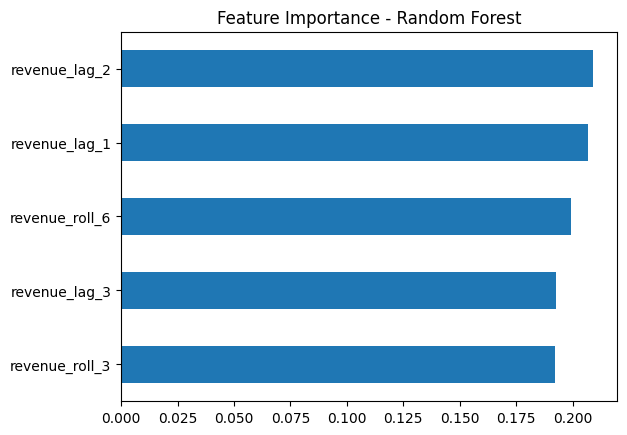

In [24]:
importances = pd.Series(rf.feature_importances_, index=FEATURES).sort_values()
importances.plot(kind='barh')
plt.title('Feature Importance - Random Forest')
plt.show()

## Conclusions
- The baseline model provides a strong reference using recent historical values.
- The Random Forest model improves performance by combining lag and rolling features.
- Lag features are the most important predictors, confirming temporal dependency.

In [44]:
# ----------------------------------------------------
# Create a single dataset for Tableau:
# Real vs Predicted Revenue
# ----------------------------------------------------

# Recover identifiers from model_df using the test index
tableau_df = (
    model_df.loc[y_test.index, ['Month', 'Country']]
    .copy()
)

# Add real revenue
tableau_df['revenue_real'] = y_test.values

# Add predicted revenue
tableau_df['revenue_predicted'] = y_pred_rf

# Sort for better visualization
tableau_df = tableau_df.sort_values(['Country', 'Month'])

# Save to CSV (Tableau-ready)
tableau_df.to_csv(
    '../data/processed/revenue_real_vs_predicted.csv',
    index=False
)

print("CSV for Tableau created: revenue_real_vs_predicted.csv")



CSV for Tableau created: revenue_real_vs_predicted.csv
